In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns

%matplotlib inline

In [41]:
df = pd.read_csv('water_potability.csv')

df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [42]:
df.shape

(3276, 10)

In [43]:
df.isna().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [45]:
df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


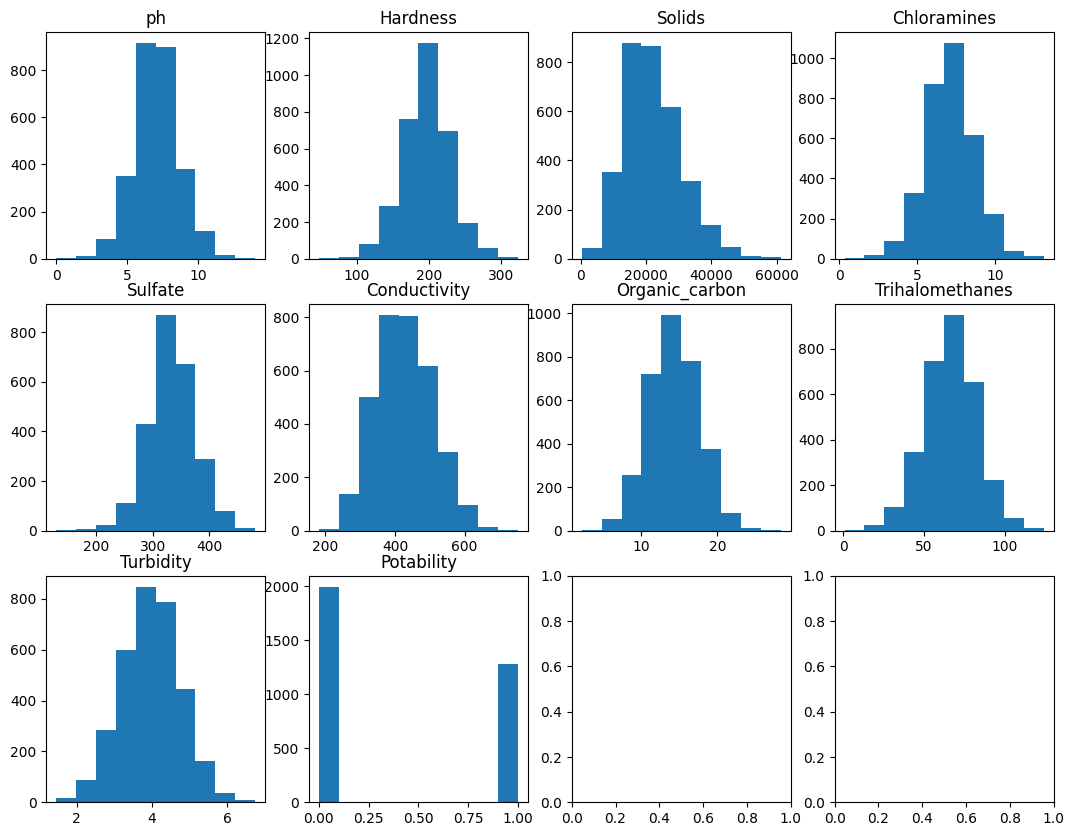

In [46]:
# Plota a distribuicao de cada feature
fig, ax = plt.subplots(3, 4, figsize=(13, 10))

row = 0
col = 0
max_col = 3

for feature in df.columns:
    ax[row, col].hist(df[feature], label=feature)
    ax[row, col].set_title(feature)
    if (col < max_col): col += 1
    else:
        row += 1
        col = 0

In [47]:
dist = df['Potability'].value_counts(normalize=True)
dist

Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64

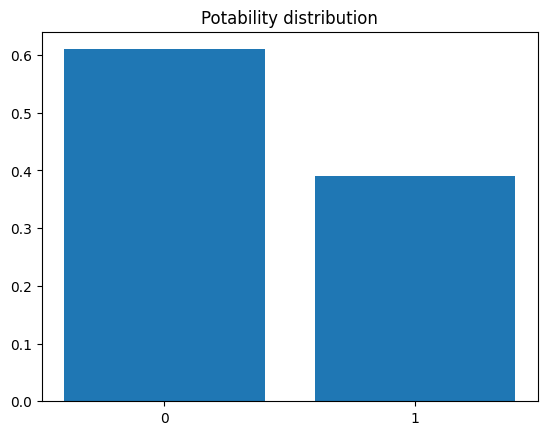

In [48]:
plt.bar(dist.index, dist)
plt.xticks([0, 1])
plt.title('Potability distribution')
plt.show()

In [49]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, train_test_split

rs = 42 # o valor que sera usado para o random_state

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Potability']), df['Potability'], test_size=.3, stratify=df['Potability'], random_state=rs)

# define as etapas de pre processamento dos dados
pre_processing = Pipeline([
    ('nan_imputer', SimpleImputer()), # substitui os valores NaN pela media
    ('normalizer', StandardScaler()) # faz a normalizacao dos dados
])

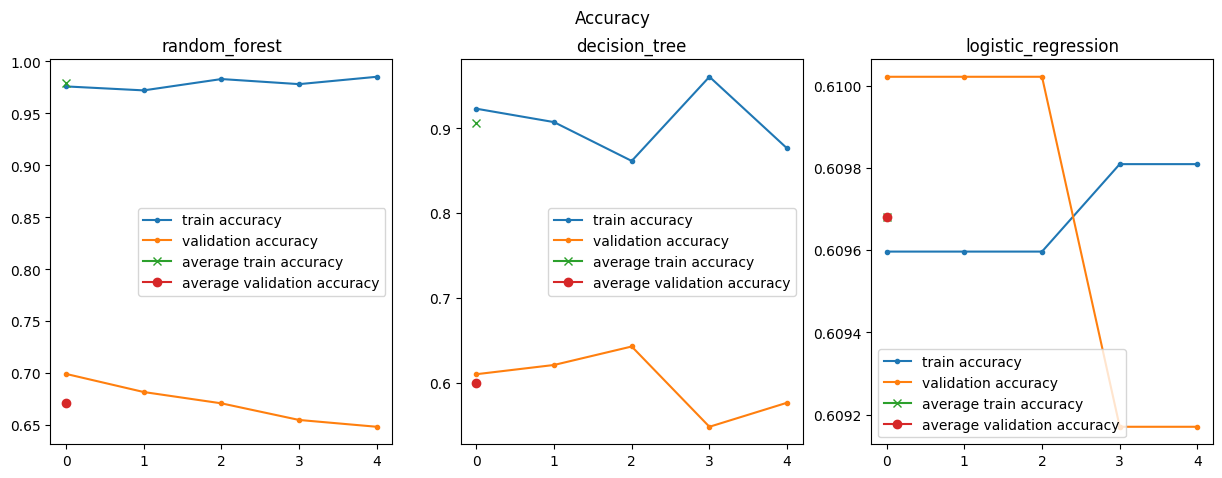

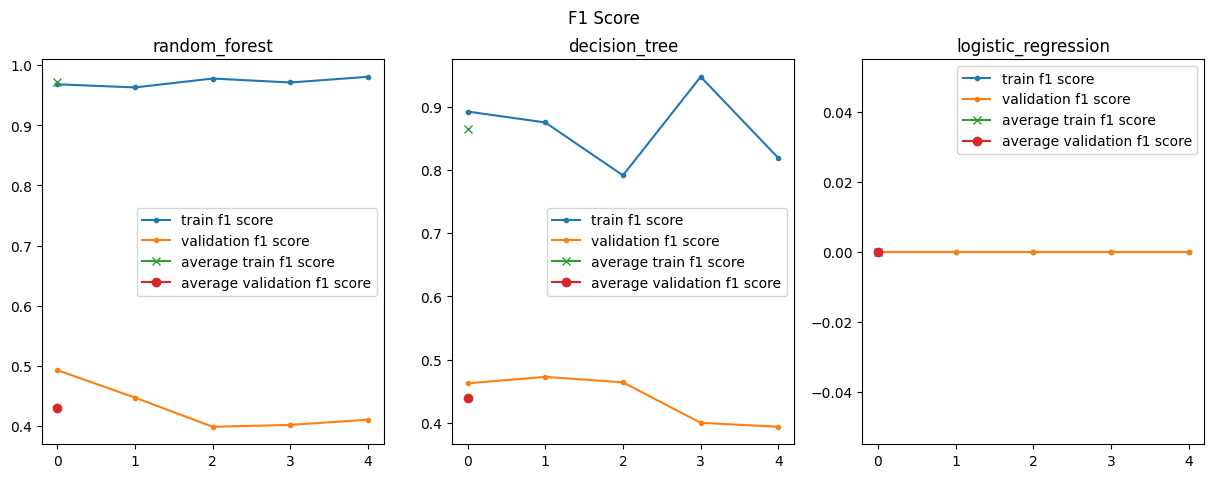

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

def create_model(model, model_name, pre_processing):
    '''Cria um modelo
    '''
    
    return Pipeline([
        ('pre_processing', pre_processing),
        (model_name, model)
    ])

random_forest = create_model(RandomForestClassifier(max_depth=15, random_state=rs), 'random_forest', pre_processing)
decision_tree = create_model(DecisionTreeClassifier(max_depth=15, random_state=rs), 'decision_tree', pre_processing)
logistic_regression = create_model(LogisticRegression(random_state=rs), 'logistic_regression', pre_processing)

models = [random_forest, decision_tree, logistic_regression]

# plota os resultados de treino e teste em diversos modelos utilizando cross validation
fig_acc, ax_acc = plt.subplots(1, 3, figsize=(15, 5))
fig_acc.suptitle('Accuracy')

fig_f1, ax_f1 = plt.subplots(1, 3, figsize=(15, 5))
fig_f1.suptitle('F1 Score')

for i, model in enumerate(models):
    results = cross_validate(model, X_train, y_train, return_train_score=True, scoring=['f1', 'accuracy'])

    model_name = list(model.named_steps.keys())[-1]

    ax_acc[i].plot(results['train_accuracy'], label='train accuracy', marker='.')
    ax_acc[i].plot(results['test_accuracy'], label='validation accuracy', marker='.')
    ax_acc[i].plot(np.mean(results['train_accuracy']), label=f'average train accuracy', marker='x')
    ax_acc[i].plot(np.mean(results['test_accuracy']), label=f'average validation accuracy', marker='o')
    ax_acc[i].set_title(model_name)
    ax_acc[i].legend()
    
    ax_f1[i].plot(results['train_f1'], label='train f1 score', marker='.')
    ax_f1[i].plot(results['test_f1'], label='validation f1 score', marker='.')
    ax_f1[i].plot(np.mean(results['train_f1']), label=f'average train f1 score', marker='x')
    ax_f1[i].plot(np.mean(results['test_f1']), label=f'average validation f1 score', marker='o')
    ax_f1[i].set_title(model_name)
    ax_f1[i].legend()

In [51]:
from sklearn.model_selection import GridSearchCV

rf = create_model(RandomForestClassifier(max_depth=10, random_state=rs), 'random_forest', pre_processing)

rf_param_grid = {
    'random_forest__n_estimators': [10, 100, 1000],
    'random_forest__criterion': ['gini', 'entropy', 'log_loss'],
    'random_forest__max_depth': [10, 100, 1000]
}

rf_grid_search = GridSearchCV(
    estimator=random_forest,
    param_grid=rf_param_grid,
    scoring=['f1', 'accuracy'],
    refit='f1',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

rf_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(estimator=Pipeline(steps=[('pre_processing',
                                        Pipeline(steps=[('nan_imputer',
                                                         SimpleImputer()),
                                                        ('normalizer',
                                                         StandardScaler())])),
                                       ('random_forest',
                                        RandomForestClassifier(max_depth=15,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'random_forest__criterion': ['gini', 'entropy',
                                                      'log_loss'],
                         'random_forest__max_depth': [10, 100, 1000],
                         'random_forest__n_estimators': [10, 100, 1000]},
             refit='f1', return_train_score=True, scoring=['f1', 'accuracy'],
             verbose=1)

In [52]:
def grid_best_parameters(grid_search, param_grid, scores_name):
    '''Printa os melhores parametros para o modelo
    '''

    print('Best parameter combination found:')
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in param_grid.keys():
        print(f'{param_name}: {best_parameters[param_name]}')

    print('')

    for score_name in scores_name:
        score_name_attribute = f'mean_test_{score_name}'
        index = grid_search.best_index_
        # plotar tbm os scores de treino
        print(f'Mean {score_name} score of the best estimator in the validation set: {grid_search.cv_results_[score_name_attribute][index]}')

In [53]:
grid_best_parameters(rf_grid_search, rf_param_grid, ['f1', 'accuracy'])

Best parameter combination found:
random_forest__n_estimators: 1000
random_forest__criterion: gini
random_forest__max_depth: 100

Mean f1 score of the best estimator in the validation set: 0.45939896538014297
Mean accuracy score of the best estimator in the validation set: 0.6785759815813759


In [54]:
xgboost = create_model(xgb.XGBClassifier(), 'xgboost', pre_processing)

xgboost_param_grid = {
    'xgboost__n_estimators': [i  for i in range(50, 1000, 50)], # [50, 100, 1000],
    'xgboost__max_depth':  [i  for i in range(3, 12, 3)], # [6, 12],
    'xgboost__learning_rate': [0.005 * i  for i in range(1, 100, 10)] # [.3, .01, .001]
}

xgboost_grid_search = GridSearchCV(
    estimator=xgboost,
    param_grid=xgboost_param_grid,
    scoring=['f1', 'accuracy'],
    n_jobs=-1,
    verbose=1,
    refit='f1',
    return_train_score=True
)

xgboost_grid_search.fit(X_train, y_train)

grid_best_parameters(xgboost_grid_search, xgboost_param_grid, ['f1', 'accuracy'])

Fitting 5 folds for each of 570 candidates, totalling 2850 fits
Best parameter combination found:
xgboost__n_estimators: 750
xgboost__max_depth: 9
xgboost__learning_rate: 0.255

Mean f1 score of the best estimator in the validation set: 0.5206335285020167
Mean accuracy score of the best estimator in the validation set: 0.6589576733167795


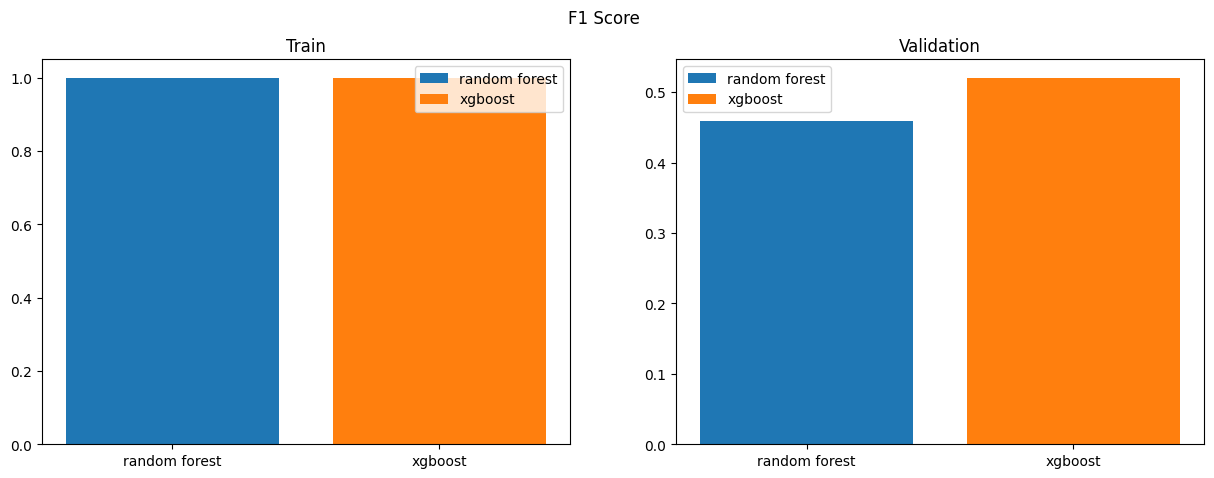

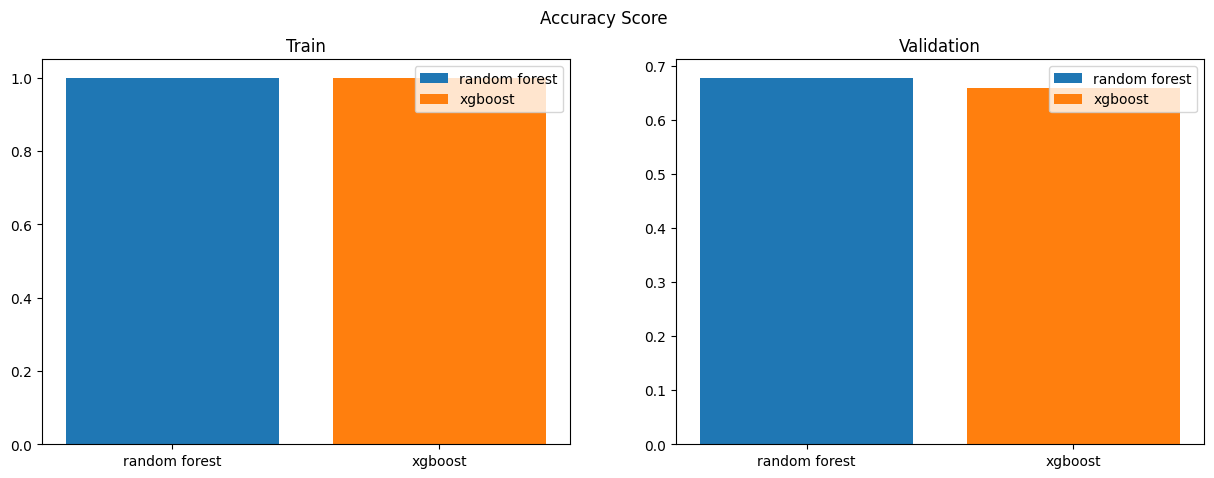

In [55]:
fig_f1, ax_f1 = plt.subplots(1, 2, figsize=(15, 5))
fig_acc, ax_acc = plt.subplots(1, 2, figsize=(15, 5))

fig_f1.suptitle('F1 Score')
ax_f1[0].set_title('Train')
ax_f1[1].set_title('Validation')

fig_acc.suptitle('Accuracy Score')
ax_acc[0].set_title('Train')
ax_acc[1].set_title('Validation')

searchs = {'random forest': rf_grid_search, 'xgboost': xgboost_grid_search}

for i, model_name in enumerate(searchs.keys()):
    index = searchs[model_name].best_index_
    ax_f1[0].bar(model_name, searchs[model_name].cv_results_['mean_train_f1'][index], label=model_name)
    ax_f1[1].bar(model_name, searchs[model_name].cv_results_['mean_test_f1'][index], label=model_name)

    ax_acc[0].bar(model_name, searchs[model_name].cv_results_['mean_train_accuracy'][index], label=model_name)
    ax_acc[1].bar(model_name, searchs[model_name].cv_results_['mean_test_accuracy'][index], label=model_name)

for ax in ax_f1:
    ax.legend()

for ax in ax_acc:
    ax.legend()

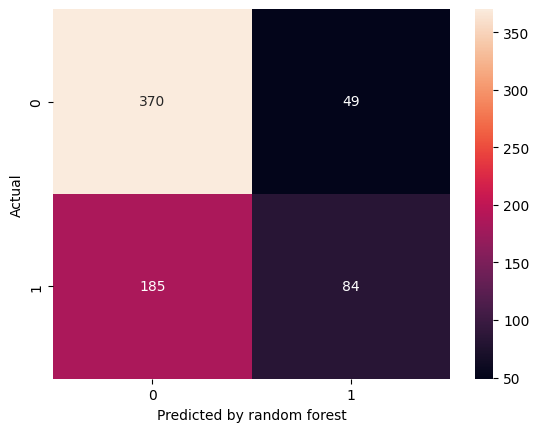

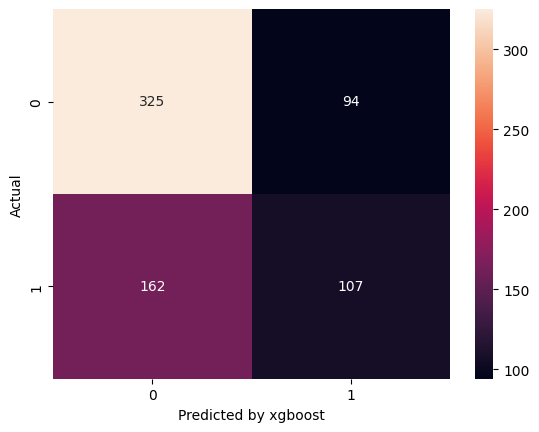

In [56]:
for i, model_name in enumerate(searchs.keys()):
    best_model = searchs[model_name].best_estimator_

    X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, test_size=.3, stratify=y_train, random_state=rs)

    best_model.fit(X_t, y_t)

    y_pred = best_model.predict(X_v)

    data = {'y': y_v, 'y_pred': y_pred}
    test_dataframe = pd.DataFrame(data, columns=['y','y_pred'])
    cm = pd.crosstab(test_dataframe['y'], test_dataframe['y_pred'], rownames=['Actual'], colnames=[f'Predicted by {model_name}'])
    sns.heatmap(cm, annot=True, fmt='d')
    plt.show()

F1 score on test set 0.4245614035087719
Accuracy on test set 0.6663275686673449


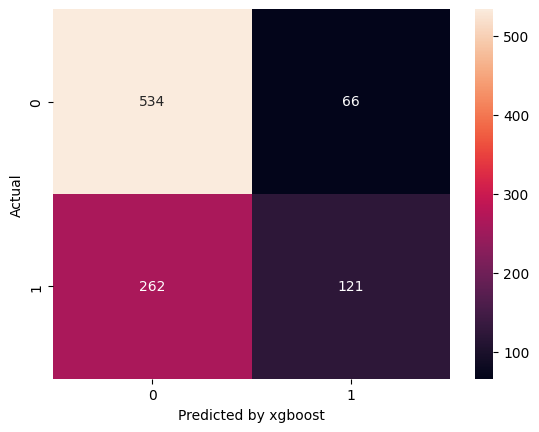

In [57]:
from sklearn.metrics import f1_score, accuracy_score

best_model = rf_grid_search.best_estimator_

best_model.fit(X_train, y_train)

pred = best_model.predict(X_test)

print(f'F1 score on test set {f1_score(y_test, pred)}')
print(f'Accuracy on test set {accuracy_score(y_test, pred)}')

data = {'y': y_test, 'y_pred': pred}
test_dataframe = pd.DataFrame(data, columns=['y','y_pred'])
cm = pd.crosstab(test_dataframe['y'], test_dataframe['y_pred'], rownames=['Actual'], colnames=[f'Predicted by {model_name}'])
sns.heatmap(cm, annot=True, fmt='d')
plt.show()